<a href="https://colab.research.google.com/github/trduc97/Spotify_classification/blob/main/label_grouping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="section1"></a>
## 1 - Importing/Installing Libraries & Datafiles
<a id="section1.1"></a>
### 1.1 - Importing/Installing Libraries

In [ ]:
# This cell handles all package installations required to run the notebook

# Package installations
!pip install xgboost
!pip install gdown
!pip install tensorflow


In [ ]:
# This cell handles all library/module imports required to run the notebook

# Data manipulation and analysis
import pandas as pd

# Data retrieval
import gdown

# Machine learning
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer, RobustScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import xgboost as xgb

# Scientific computing
import numpy as np
from scipy.stats import ks_2samp

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


<a id="section1.2"></a>
### 1.2 - Importing Datasets

In [ ]:
# Storing the Google Drive URL of the .csv files to be downloaded
train_url = 'https://drive.google.com/uc?id=1xta0FaTHYVKjLbc7ztPgDME5nsqZGoPz'
test_url = 'https://drive.google.com/uc?id=1O0DtiXCsgl7CDV52yOvVWwaKriXjqWxL'

# Storing the output path of the .csv files to be downloaded
train_file = 'CS98XClassificationTrain.csv'
test_file = 'CS98XClassificationTest.csv'

# Downloading the .csv files from Google Drive
gdown.download(train_url, train_file, quiet=False, )
gdown.download(test_url, test_file, quiet=False)

# Reading the .csv files into a DataFrame
train_set = pd.read_csv(train_file)
test_set = pd.read_csv(test_file)

# Renaming the 'top genre' column to 'top_genre' in the 'train_set' and 'test_set' DataFrames for the purpose of accessibility
train_set.rename(columns={'top genre': 'top_genre'}, inplace=True)
test_set.rename(columns={'top genre': 'top_genre'}, inplace=True)


Downloading...
From: https://drive.google.com/uc?id=1xta0FaTHYVKjLbc7ztPgDME5nsqZGoPz
To: /content/CS98XClassificationTrain.csv
100%|██████████| 39.1k/39.1k [00:00<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O0DtiXCsgl7CDV52yOvVWwaKriXjqWxL
To: /content/CS98XClassificationTest.csv
100%|██████████| 8.57k/8.57k [00:00<00:00, 12.5MB/s]


<a id="section2"></a>
## 2 - Data Cleaning and Exploration
<a id="section2.1"></a>
### 2.1 - Investigating Duplicate Rows

In [ ]:
# Checking for duplicate rows in the 'train_set' and 'test_set' DataFrames using the 'Id' columns
print(f"There are {train_set.duplicated(subset='Id').sum()} duplicate 'Id' values in the 'train_set' DataFrame")
print(f"There are {test_set.duplicated(subset='Id').sum()} duplicate 'Id' values in the 'test_set' DataFrame")

# Checking for duplicate rows in the 'train_set' and 'test_set' DataFrames excluding the 'Id' columns
print(f"There are {train_set.drop(columns='Id').duplicated().sum()} duplicate rows in the 'train_set' DataFrame with the 'Id' column excluded")
print(f"There are {test_set.drop(columns='Id').duplicated().sum()} duplicate rows in the 'test_set' DataFrame with the 'Id' column excluded")


There are 0 duplicate 'Id' values in the 'train_set' DataFrame
There are 0 duplicate 'Id' values in the 'test_set' DataFrame
There are 1 duplicate rows in the 'train_set' DataFrame with the 'Id' column excluded
There are 0 duplicate rows in the 'test_set' DataFrame with the 'Id' column excluded


In [ ]:
# Storing the length of the 'train_set' DataFrame
train_set_length_pre = len(train_set)

# Handling duplicate rows in the 'train_set' DataFrame
train_set = train_set.drop_duplicates(subset=train_set.columns.difference(['Id']))

# Resetting the index of the 'train_set' DataFrame to handle the dropped rows
train_set.reset_index(drop=True, inplace=True)

# Checking that the rows have been successfully removed
print(f"{train_set_length_pre - len(train_set)} row(s) have been removed from the 'train_set' DataFrame")


1 row(s) have been removed from the 'train_set' DataFrame


<a id="section2.2"></a>
### 2.2 - EDA and Initial Cleaning
<a id="section2.2.1"></a>
#### 2.2.1 - Comparing the Distribution of the Numerical Columns in the Train and Test Datasets

In [ ]:
# Storing the numerical columns from the 'train_set' and 'test_set' DataFrames in separate DataFrames
train_set_numerical = train_set.select_dtypes(include=[np.number])
test_set_numerical = test_set.select_dtypes(include=[np.number])

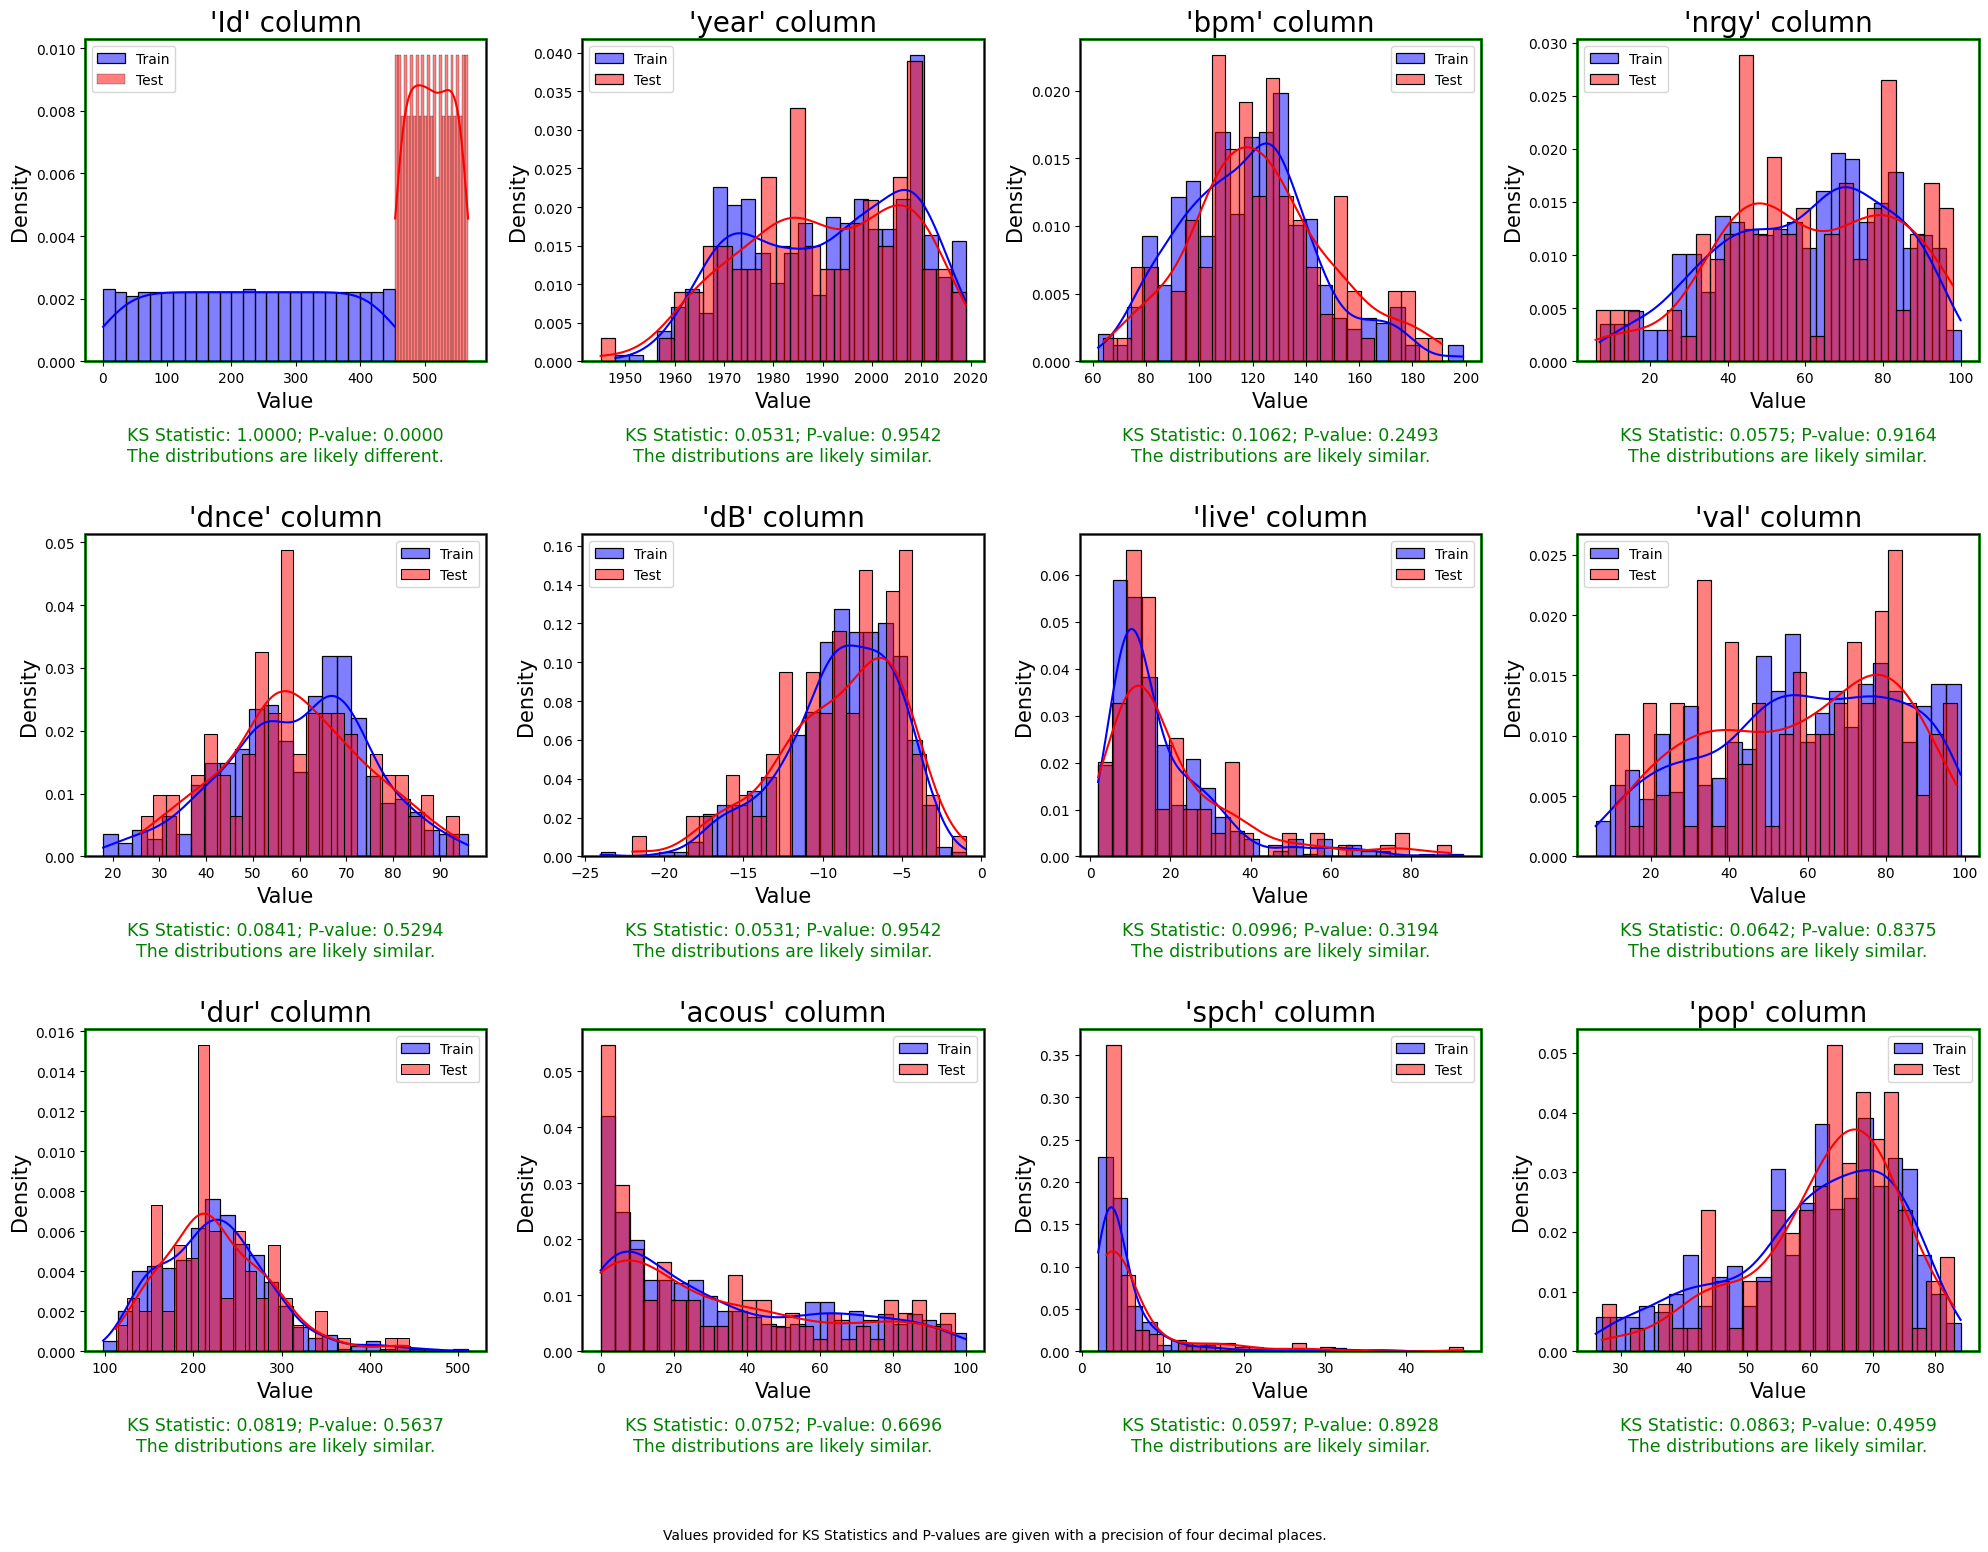

In [ ]:
# Storing the number of numerical columns in the 'train_set' DataFrame inside a variable
num_cols = len(train_set_numerical.columns)

# Creating a subplot for each numerical column in the 'train_set' and 'test_set' DataFrames
fig, axes = plt.subplots(num_cols // 4, 4, figsize=(20, 15))
axes = axes.flatten()

for i in range(num_cols):
    ax = axes[i]
    # Overlaying histogram and KDE plot for 'train' dataset
    sns.histplot(train_set_numerical.iloc[:, i], ax=ax, color='blue', label='Train', kde=True, stat="density", alpha=0.5, bins=25)
    # Overlaying histogram and KDE plot for 'test' dataset
    sns.histplot(test_set_numerical.iloc[:, i], ax=ax, color='red', label='Test', kde=True, stat="density", alpha=0.5, bins=25)
    ax.set_xlabel("Value", fontsize=15)
    ax.set_ylabel("Density", fontsize=15)
    ax.set_title(f"'{train_set_numerical.columns[i]}' column", fontsize=20)
    ax.legend()
    ax.patch.set_edgecolor('green')
    ax.patch.set_linewidth(2)
    # Applying the Kolmogorov-Smirnov Test to the set of columns
    ks_statistic, p_value = ks_2samp(train_set_numerical.iloc[:, i], test_set_numerical.iloc[:, i])
    if p_value > 0.05:
        text = "The distributions are likely similar.\n"
    else:
        text = "The distributions are likely different.\n"
    ax.text(0.5, -0.2, f"KS Statistic: {ks_statistic:.4f}; P-value: {p_value:.4f}\n{text}", ha='center', va='top', transform=ax.transAxes, color='green', fontsize=12.5)

# Adjusting the layout of the plot and adding text
plt.tight_layout()
fig.text(0.5, -0.03, "Values provided for KS Statistics and P-values are given with a precision of four decimal places.", ha="center")
plt.show()


**Through examination of the plots and associated Kolmogorov-Smirnov Tests above, it is safe to conclude that all the columns (excluding the 'Id' column) in the 'train_set' DataFrame have similar distributions to their counterpart in the 'test_set' DataFrame.**


<a id="section2.2.2"></a>
#### 2.2.2 - Investigating Missing Values

In [ ]:
# Obtaining a summary of the 'train_set' DataFrame which will show any missing values
train_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         452 non-null    int64 
 1   title      452 non-null    object
 2   artist     452 non-null    object
 3   year       452 non-null    int64 
 4   bpm        452 non-null    int64 
 5   nrgy       452 non-null    int64 
 6   dnce       452 non-null    int64 
 7   dB         452 non-null    int64 
 8   live       452 non-null    int64 
 9   val        452 non-null    int64 
 10  dur        452 non-null    int64 
 11  acous      452 non-null    int64 
 12  spch       452 non-null    int64 
 13  pop        452 non-null    int64 
 14  top_genre  437 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.1+ KB


In [ ]:
# Filtering the 'train_set' DataFrame to display the rows where the 'top_genre' column has missing values
train_set[train_set.isnull()["top_genre"]==True]


,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top_genre
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
8,9,Someone Elses Roses,Joan Regan,2019,100,14,29,-10,15,32,143,89,3,34,NaN
26,27,Drinks On The House,Green Martini Keys,2016,97,16,57,-16,11,15,181,100,5,28,NaN
71,73,Pachuko Hop,Ike Carpenter Orchestra,2006,83,53,48,-9,34,80,135,59,3,28,NaN
89,91,Little Things Means A Lot,Jayne Mansfield,2008,109,29,70,-15,16,63,172,36,4,29,NaN
97,99,The Lady Is A Tramp,Mel Torme & the Mel-Tones,2016,138,60,41,-8,41,54,170,81,6,40,NaN
219,221,If I Give My Heart To You,The Teddy Bears,2011,113,29,49,-10,12,29,118,86,3,40,NaN
251,253,Happy Days And Lonely Nights,Suzi Miller And Johnson Brothers,2012,142,38,65,-8,13,69,146,43,3,27,NaN
264,266,Stairway Of Love,Terry Dene,2015,93,62,62,-7,25,86,120,55,4,27,NaN
265,267,You,Ten Sharp,1991,174,90,41,-8,19,67,273,43,3,61,NaN


<a id="section2.2.3"></a>
#### 2.2.3 - Handling Missing Values

In [ ]:
# Updating the 'top_genre' values for rows in which they are missing
train_set.loc[train_set['title'] == 'Unchained Melody', 'top_genre'] = 'pop'
train_set.loc[train_set['title'] == 'Someone Elses Roses', 'top_genre'] = 'adult standards'
train_set.loc[train_set['title'] == 'Drinks On The House', 'top_genre'] = 'pop'
train_set.loc[train_set['title'] == 'Pachuko Hop', 'top_genre'] = 'blues'
train_set.loc[train_set['title'] == 'Little Things Means A Lot', 'top_genre'] = 'blues'
train_set.loc[train_set['title'] == 'The Lady Is A Tramp', 'top_genre'] = 'pop'
train_set.loc[train_set['title'] == 'If I Give My Heart To You', 'top_genre'] = 'pop'
train_set.loc[train_set['title'] == 'Happy Days And Lonely Nights','top_genre'] = 'rock'
train_set.loc[train_set['title'] == 'Stairway Of Love','top_genre'] = 'rock'
train_set.loc[train_set['title'] == 'You', 'top_genre'] = 'pop'
train_set.loc[train_set['title'] == 'No Other Love' , 'top_genre'] = 'adult standards'
train_set.loc[train_set['title'] == "Hot Diggity" , 'top_genre'] = 'folk'
train_set.loc[train_set['title'] == "Ain't That Just the Way" , 'top_genre'] = 'r&b'
train_set.loc[train_set['title'] == "I Promised Myself" , 'top_genre'] = 'pop'

# Dropping rows in which the missing values for 'top_genre' could not be located (I've Waited So Long - Anthony Newley = Dance or Electronic?)
train_set = train_set.dropna(axis=0)

# Resetting the index of the 'train_set' DataFrame to handle the dropped row
train_set.reset_index(drop=True, inplace=True)

# check again for null values
train_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         451 non-null    int64 
 1   title      451 non-null    object
 2   artist     451 non-null    object
 3   year       451 non-null    int64 
 4   bpm        451 non-null    int64 
 5   nrgy       451 non-null    int64 
 6   dnce       451 non-null    int64 
 7   dB         451 non-null    int64 
 8   live       451 non-null    int64 
 9   val        451 non-null    int64 
 10  dur        451 non-null    int64 
 11  acous      451 non-null    int64 
 12  spch       451 non-null    int64 
 13  pop        451 non-null    int64 
 14  top_genre  451 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.0+ KB


<a id="section2.2.4"></a>
#### 2.2.4 - Checking for outliers

In [ ]:
# Storing the quantiles inside variables and calculating the interquartile range for the numerical columns of the 'train_set' DataFrame
Q1, Q3 = train_set_numerical.quantile(0.25), train_set_numerical.quantile(0.75)
IQR = Q3 - Q1

# Calculating the number of outliers for each of the numerical columns in the 'train_set' DataFrame
outliers = ((train_set_numerical < (Q1 - 1.5 * IQR)) | (train_set_numerical > (Q3 + 1.5 * IQR))).sum()

# Sorting the numerical columns by their number of outliers
outliers_sorted = outliers.sort_values(ascending=False)


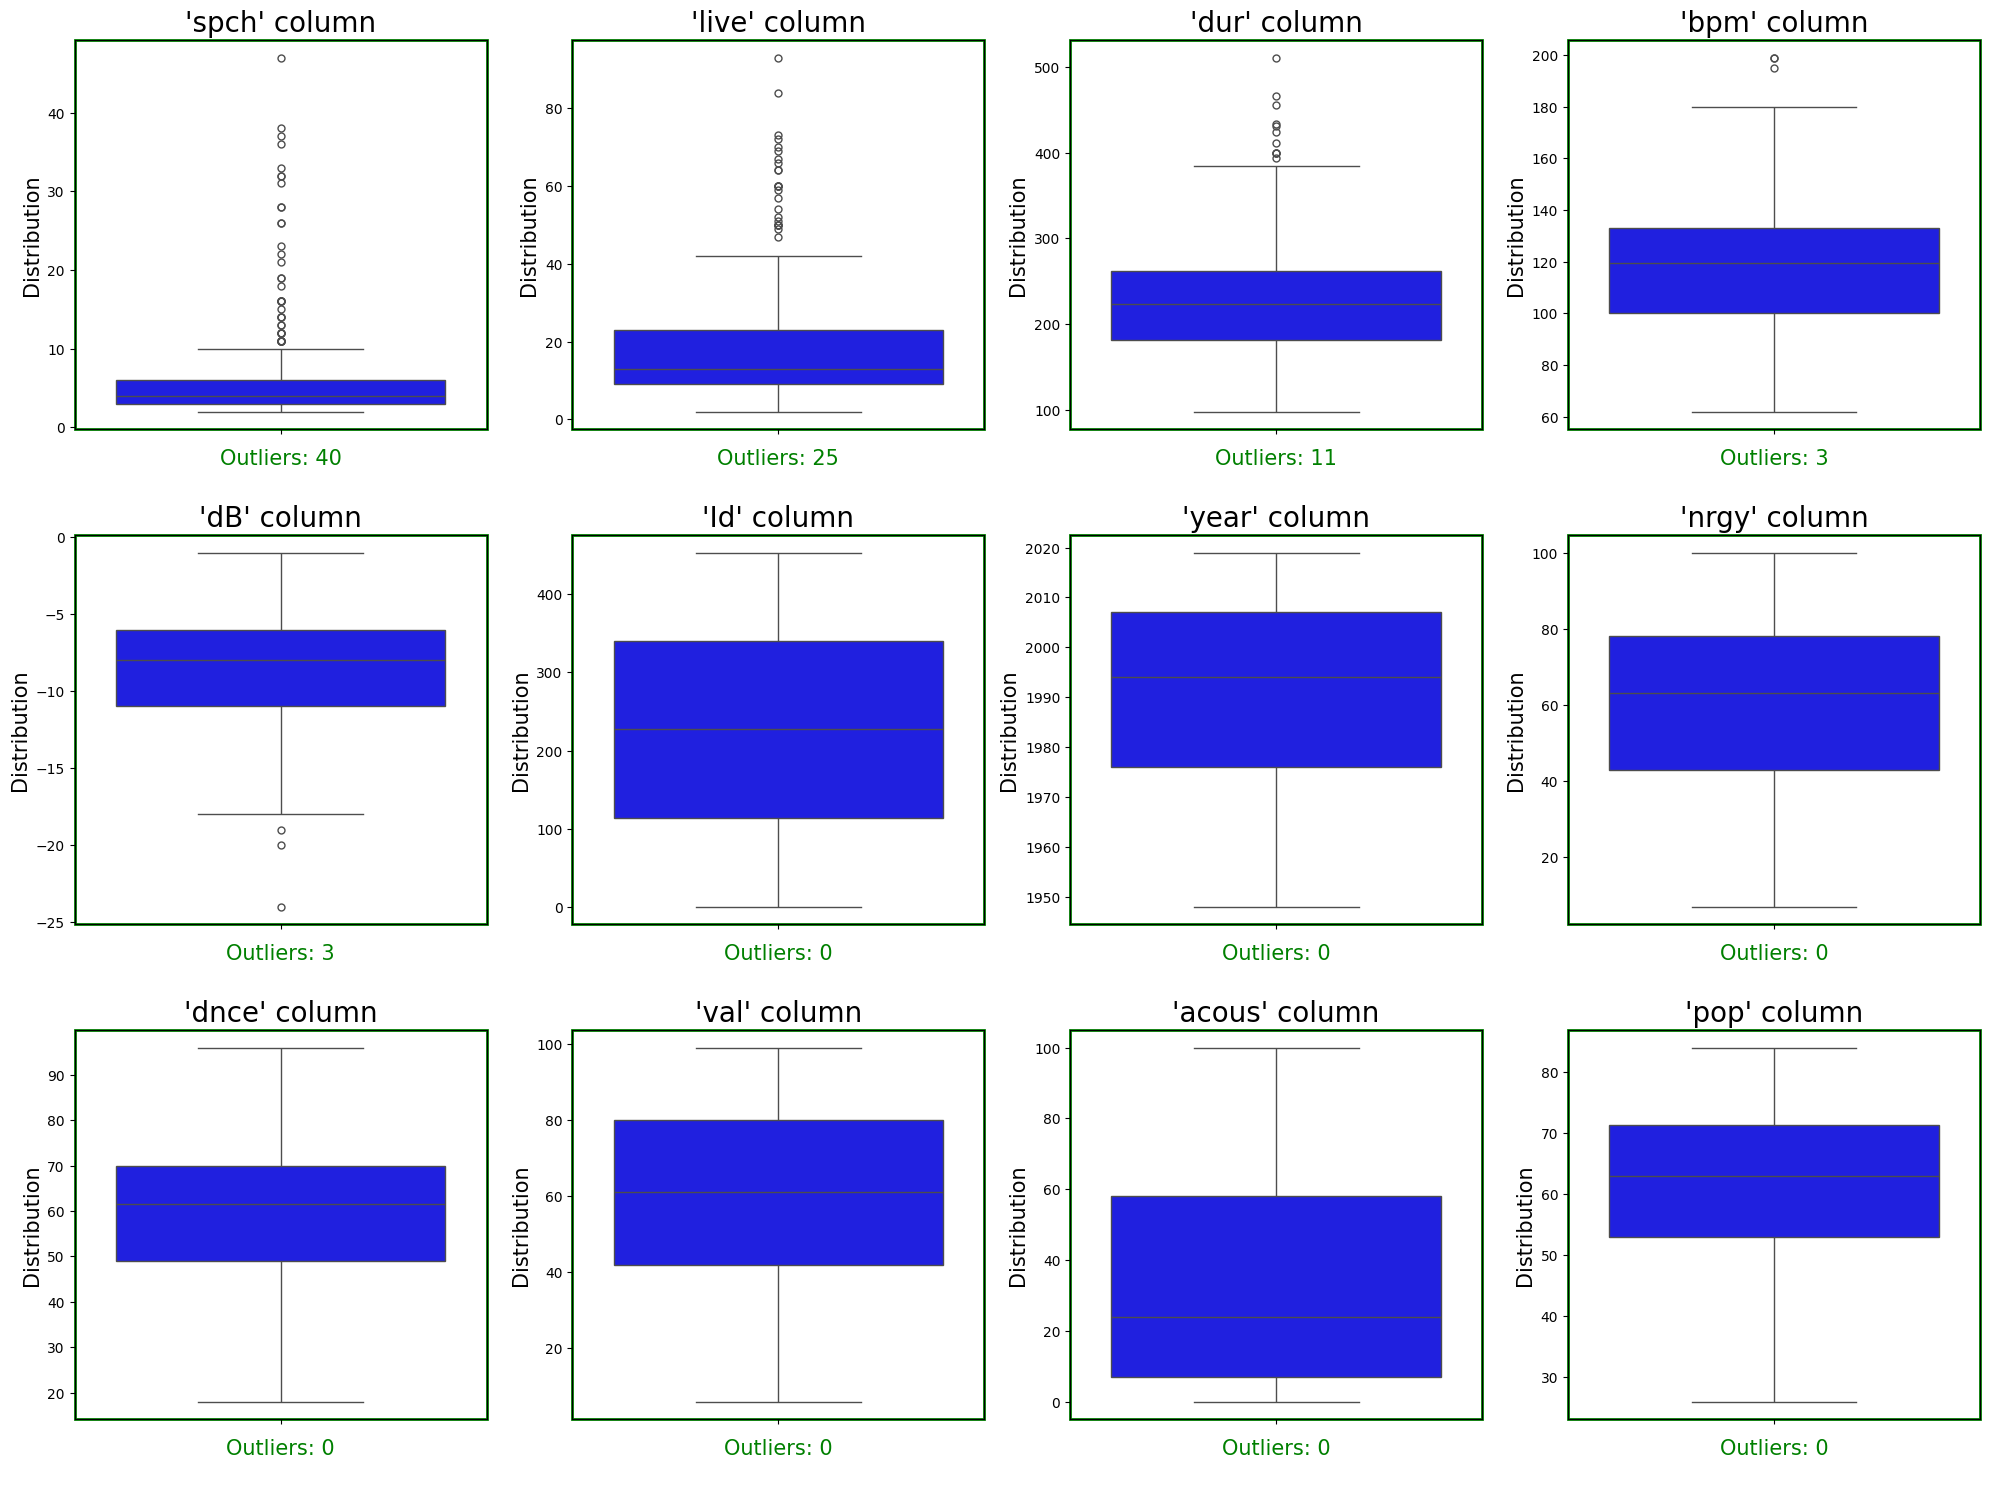

In [ ]:
# Creating a subplot for each numerical column
fig, axes = plt.subplots(num_cols // 4, 4, figsize=(20, 15))
axes = axes.flatten()

for num, col in enumerate(outliers_sorted.index.tolist()):
    ax = axes[num]
    sns.boxplot(data=train_set_numerical[col], ax=ax, color='blue', fliersize=5)
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_ylabel("Distribution", fontsize=15)
    ax.set_title(f"'{col}' column", fontsize=20)
    ax.text(0.5, -0.05, f"Outliers: {outliers_sorted[col]}\n", ha='center', va='top', transform=ax.transAxes, color='green', fontsize=15)
    ax.patch.set_edgecolor('green')
    ax.patch.set_linewidth(2)

# Adjusting the layout of the plot
plt.tight_layout()
plt.show()


**As can be seen from the plots and their associated outlier values above, numerical columns in the 'train_set' such as 'spch', 'live', 'dur' have a significant number of outliers.**

<a id="section2.2.5"></a>
#### 2.2.5 - Checking the Distribution of Classes

In [ ]:
category_percentages = train_set["top_genre"].value_counts().sort_values(ascending=False).apply(lambda x: (x / 451) * 100).round(1)
category_percentages.name = "Percentage of Total"
category_percentages


adult standards            15.3
album rock                 14.6
dance pop                  13.5
glam rock                   3.5
brill building pop          3.5
                           ... 
mellow gold                 0.2
avant-garde jazz            0.2
german alternative rock     0.2
acoustic blues              0.2
alternative rock            0.2
Name: Percentage of Total, Length: 88, dtype: float64

**The series shown above reveals that the 'train_set' DataFrame contains a disproportionately high amount of entries for 'adult standards', 'album rock' and 'dance pop', with the rest of the categories each representing no more than 3.5% of the total.**

<a id="section2.2.6"></a>
#### 2.2.6 - Checking for correlation

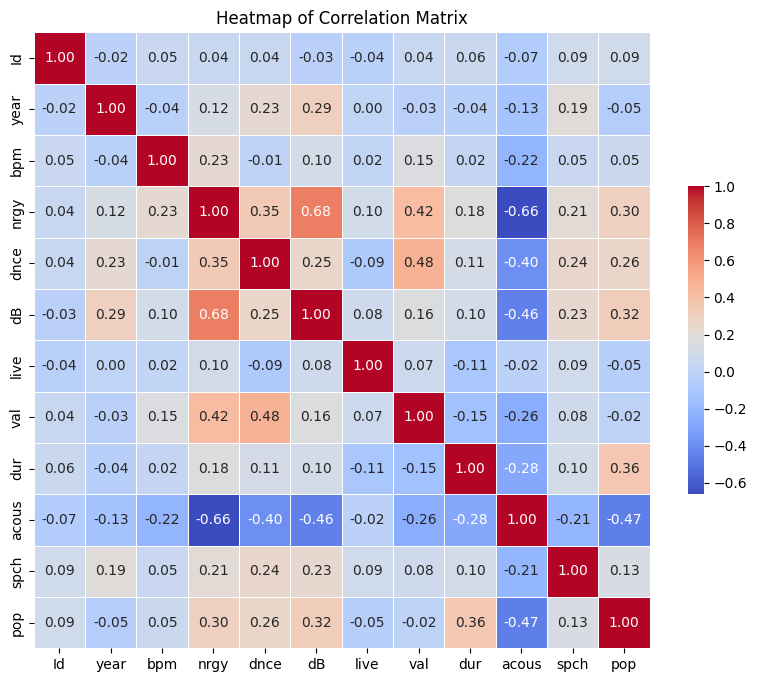

In [ ]:
corr_matrix = train_set_numerical.corr()
corr_matrix["pop"].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation Matrix')

plt.show()


**From the above plot it can be seen that most features in the dataset exhibit a relatively low level of interdependence, with the notable exception of the positive correlation between 'nrgy' and 'dB' and the negative correlation between 'acous' and 'nrgy'.**

<a id="section2.3"></a>
## 2.3 - Feature Engineering
<a id="section2.3.1"></a>
### 2.3.1 - Binning Values for Year

In [ ]:
# Due to the tracks being released over such a large time span, we can simplify the data through binning by grouping the dates into 5 year intervals
def assign_group(year):
    if 1948 <= year <= 1954:
        return 1
    else:
        return ((year - 1954)//5)+2

# Applying the calculation
train_set['year'] = train_set['year'].apply(assign_group)
test_set['year'] = test_set['year'].apply(assign_group)


<a id="section2.3.2"></a>
#### 2.3.2 - Categorizing Numeric Variables & Further Feature Engineering

WE CANNOT GROUP TRAIN AND TEST SET TOGETHER AND SCALE THE COLUMNS
TO AVOID DATA LEAKAGE, THE COLUMN WILL BE SCALE LATER IN SECTION 3.2

In [ ]:
'''

# Creating a list containing both the 'train_set' and 'test_set' DataFrames
set_dataframes = [train_set, test_set]

for i in set_dataframes:
    # Categorizing Certain Numeric Variables
    i['tempo_category'] = pd.cut(i['bpm'], bins=[0, 100, 140, 200], labels=[2, 4, 6])
    i['energy_level'] = pd.cut(i['nrgy'], bins=[0, 33, 66, 100], labels=[3, 6, 9])

    # Calculate the average of energy and danceability for each song
    i['energy_danceability'] = (i['nrgy'] + i['dnce']) / 2

    # Categorize the combined features into categorical values
    i['energy_danceability_level'] = pd.cut(i['energy_danceability'], bins=[0, 33, 66, 100], labels=[12, 8, 4])
    current_year = pd.to_datetime('today').year
    i['years_since_release'] = current_year - i['year']

    def normalizing_dB(dB, set):
        return (dB - set['dB'].min()) / (set['dB'].max() - set['dB'].min())

    # Next let us engineer some interactive features based on reasons given above
    def engineered_interaction_features(row):
        normalized_dB = normalizing_dB(row['dB'], i)

        #Note that louder songs generally have higher tempo. So their relationship is pretty much directly proportional
        rhythm_intensity= normalized_dB * row['bpm']

        #More danceable songs are shorter, suggesting an inverse relationship
        dancefloor_time = (1 - row['dur'] / train_set['dur'].max()) * row['dnce']
        club_hit_factor = normalized_dB * row['bpm'] * (1 - row['dur'] / train_set['dur'].max())
        viral_potential = (normalized_dB * row['bpm'] * (1 - row['spch'] / train_set['spch'].max())) * row['pop']
        return pd.Series([rhythm_intensity, dancefloor_time, club_hit_factor, viral_potential], index=['rhythm_intensity', 'dancefloor_time', 'club_hit_factor', 'viral_potential'])

    # Applying the function to create new features
    engineered_interaction_features = i.apply(engineered_interaction_features, axis=1)
    i = pd.concat([i, engineered_interaction_features], axis=1)

'''


"  \n\n# Creating a list containing both the 'train_set' and 'test_set' DataFrames\nset_dataframes = [train_set, test_set]\n\nfor i in set_dataframes:\n    # Categorizing Certain Numeric Variables \n    i['tempo_category'] = pd.cut(i['bpm'], bins=[0, 100, 140, 200], labels=[2, 4, 6])\n    i['energy_level'] = pd.cut(i['nrgy'], bins=[0, 33, 66, 100], labels=[3, 6, 9])\n    \n    # Calculate the average of energy and danceability for each song\n    i['energy_danceability'] = (i['nrgy'] + i['dnce']) / 2\n    \n    # Categorize the combined features into categorical values\n    i['energy_danceability_level'] = pd.cut(i['energy_danceability'], bins=[0, 33, 66, 100], labels=[12, 8, 4])\n    current_year = pd.to_datetime('today').year\n    i['years_since_release'] = current_year - i['year']\n    \n    def normalizing_dB(dB, set):\n        return (dB - set['dB'].min()) / (set['dB'].max() - set['dB'].min())\n\n    # Next let us engineer some interactive features based on reasons given above\n   

In [ ]:
train_df = train_set.copy()
test_df = test_set.copy()


<a id="section2.4"></a>
## 2.4 - Data Transformation
<a id="section2.4.1"></a>
### 2.4.1 - Applying TFIDF on the 'title' column

#### (a) Apply on the training set

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Taking the title column
text_data = train_df['title']

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the text data and transform the text data into TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(text_data)

# Convert the result to a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

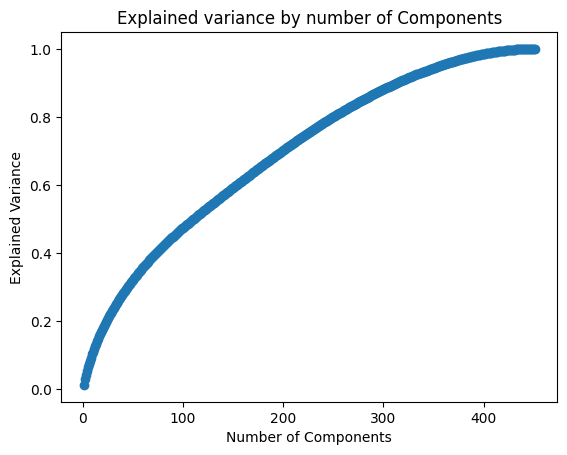

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
# Calculate the explained variance for different numbers of components
explained_variance = []
for n in range(1, min(tfidf_df.shape)+1):
    svd = TruncatedSVD(n_components=n)
    svd.fit(tfidf_df)
    explained_variance.append(svd.explained_variance_ratio_.sum())

# Plot the explained variance
plt.plot(range(1, min(tfidf_df.shape)+1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained variance by number of Components')
plt.show()

In [ ]:
# Iterate over the list and find the index of the first value > 0.9
index = next((i for i, val in enumerate(explained_variance) if val > 0.9), None)

if index is not None:
    print("Index of the first value > 0.9:", index)

#index =313

Index of the first value > 0.9: 313


In [ ]:
# Initialize TruncateSVD
svd = TruncatedSVD(n_components=index)  # Set the desired number of components

# Apply truncatesvd to tfidf_df
tfidf_svd = svd.fit_transform(tfidf_df)

# Convert tfidf_svd to DataFrame
tfidf_svd_df = pd.DataFrame(tfidf_svd, columns=[f'tfidf_svd_{i+1}' for i in range(tfidf_svd.shape[1])])

#### (b) Transform the test set

In [ ]:
# Applying the transformation on the test set
text_data = test_df['title']

# Fit the vectorizer on the text data and transform the text data into TF-IDF features
tfidf_features = tfidf_vectorizer.transform(text_data)

# Convert the result to a DataFrame
tfidf_df_test = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Apply TruncateSVD to tfidf_df_test
tfidf_svd_test = svd.transform(tfidf_df_test)

# Convert tfidf_svd_test to DataFrame
tfidf_svd_test_df = pd.DataFrame(tfidf_svd_test, columns=[f'tfidf_svd_{i+1}' for i in range(tfidf_svd.shape[1])])

<a id="section2.4.2"></a>
### 2.4.2 - Applying One-hot Encoding to the Artist Column

#### (a) Apply on the training set

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore') #to hanđle artists that newly appear on the test set

# Fit and transform the 'artist' column in X_train_encoded
one_hot_encoded_train = encoder.fit_transform(train_df[['artist']])

# Convert the encoded data into a DataFrame
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train.toarray(), columns=encoder.get_feature_names_out(['artist']))

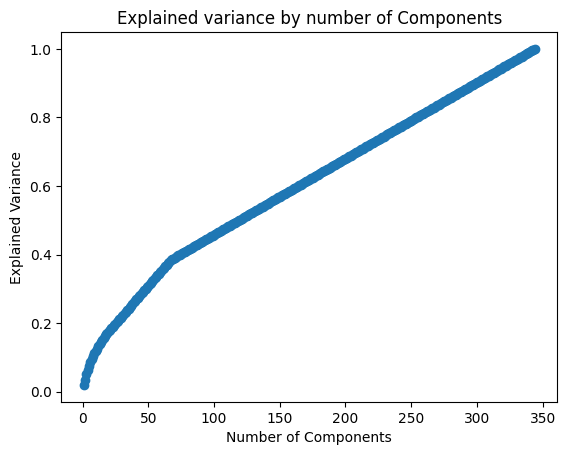

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
# Calculate the explained variance for different numbers of components
explained_variance_artist = []
for n in range(1, min(one_hot_encoded_train_df.shape)+1):
    svd = TruncatedSVD(n_components=n)
    svd.fit(one_hot_encoded_train_df)
    explained_variance_artist.append(svd.explained_variance_ratio_.sum())

# Plot the explained variance
plt.plot(range(1, min(one_hot_encoded_train_df.shape)+1), explained_variance_artist, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained variance by number of Components')
plt.show()

In [ ]:
# Iterate over the list and find the index of the first value > 0.9
index = next((i for i, val in enumerate(explained_variance_artist) if val > 0.9), None)

if index is not None:
    print("Index of the first value > 0.9:", index)
#index = 298

Index of the first value > 0.9: 298


In [ ]:
# Initialize TruncateSVD
svd = TruncatedSVD(n_components=index)  # setting the optimal values index = 299

# Apply SVD to artist one hot encoding
artist_svd = svd.fit_transform(one_hot_encoded_train_df)

# Convert artist_svd_test to DataFrame
artist_svd_df = pd.DataFrame(artist_svd, columns=[f'artist_svd_{i+1}' for i in range(artist_svd.shape[1])])

#### (b) Apply on the test set

In [ ]:
# Apply trasnformation on the test set
one_hot_encoded_test = encoder.transform(test_df[['artist']])

# Convert the encoded data into a DataFrame
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test.toarray(), columns=encoder.get_feature_names_out(['artist']))

# Apply svd to the test set
artist_svd_test = svd.transform(one_hot_encoded_test_df)

# Convert artist_svd_test to DataFrame
artist_svd_test_df = pd.DataFrame(artist_svd_test, columns=[f'artist_svd_{i+1}' for i in range(artist_svd_test.shape[1])])

<a id="section2.4.3"></a>
### 2.4.3 - Concatenate the new DataFrames

In [ ]:
# Concatenate tfidf_svd_df
train_svd = pd.concat([train_df.reset_index(drop=True), tfidf_svd_df.reset_index(drop=True)], axis=1)

# Concatenate artist_svd_df
train_svd = pd.concat([train_svd.reset_index(drop=True), artist_svd_df.reset_index(drop=True)], axis=1)

In [ ]:
# Concatenate tfidf_svd_test_df
test_svd = pd.concat([test_df.reset_index(drop=True), tfidf_svd_test_df.reset_index(drop=True)], axis=1)

# Concatenate artist_svd_test_df
test_svd = pd.concat([test_svd.reset_index(drop=True), artist_svd_test_df.reset_index(drop=True)], axis=1)


<a id="section2.4.4"></a>
### 2.4.4 - Dropping Unnecessary Columns from the 'train_svd' and 'test_svd' DataFrames

In [ ]:
train_svd, test_svd = train_svd.drop(['Id','artist','title'], axis=1), test_svd.drop(['Id','artist','title'], axis=1)


In [ ]:
train_svd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Columns: 623 entries, year to artist_svd_298
dtypes: float64(611), int64(11), object(1)
memory usage: 2.1+ MB


In [ ]:
test_svd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Columns: 622 entries, year to artist_svd_298
dtypes: float64(611), int64(11)
memory usage: 549.2 KB


<a id="section3"></a>
#3 - Preparing the Datasets for Training

In [ ]:
train_scaled = train_svd.copy()
test_scaled = test_svd.copy()


<a id="section3.1"></a>
### 3.1 - Splitting Training and Validation Set (EMPTY SECTION!)

WE CAN SKIP THIS SECTION BUT ALSO INCLUDE THAT NOT DOING THIS WILL LED TO THE TRAINING PROCESS HAVING OVERFITTED RESULT AND EXPECT REDUCED ACCURACY IN THE TEST_SET

In [ ]:
"""
    Duc, I left out the part of splitting the train_set into training and validation sets.
    This is because I thought it could be redundant to split and then later use the train_set_full and test_set_full
    on the models all afresh
    And then perform the scaling all over again on the full X_train...
    Instead, I brought in the y_test file and directly created the X_train, y_train,X_test, and y_test directly
    I could correct this and execute the validation split if you think otherwise

"""

<a id="section3.2"></a>
### 3.2 - Feature Scaling

In [ ]:
# Columns to apply Box-Cox and yeo-johnson transformation
boxcox_cols = ['spch', 'live', 'dur']
yeo_johnson_col = ['acous']

# Columns to apply StandardScaler
standard_cols = ['year', 'bpm', 'nrgy', 'dnce', 'val', 'dB','pop']

# Create a pipeline for scaling data
scaling_pipeline = ColumnTransformer([
    ('boxcox', PowerTransformer(method='box-cox', standardize=False), boxcox_cols),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=False), yeo_johnson_col),
    ('standard', StandardScaler(), standard_cols)
])

# All columns to scaled
scale_cols = boxcox_cols+yeo_johnson_col+standard_cols

# Apply the transformations
train_scaled[scale_cols] = scaling_pipeline.fit_transform(train_scaled[scale_cols])

# Convert the result back to a DataFrame (optional)
test_scaled[scale_cols] = scaling_pipeline.transform(test_scaled[scale_cols])


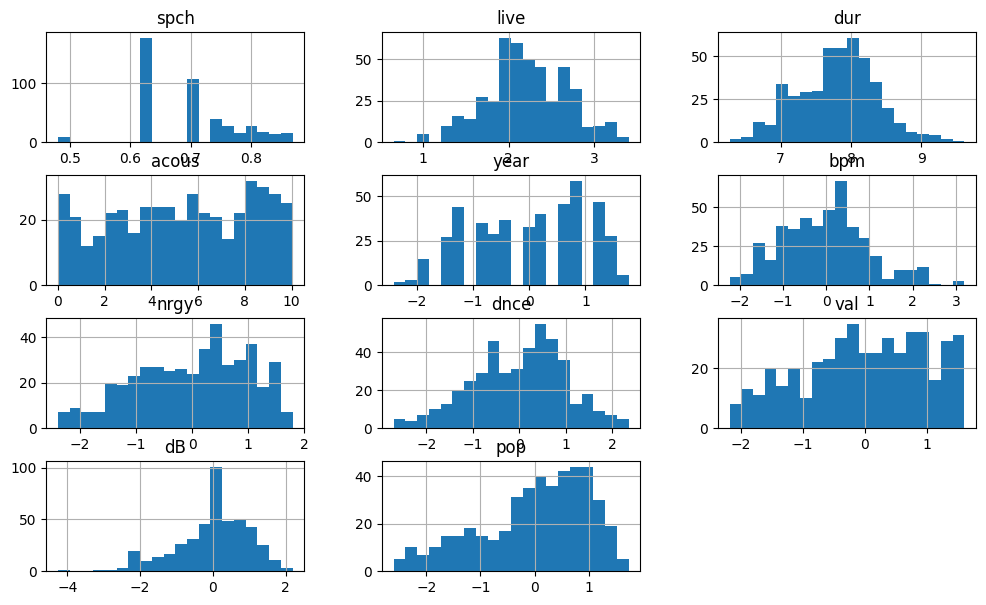

In [ ]:
# DECISION ON THIS CODE DUE BY END OF DAY 25/02/2024 - REMOVE OR IMPLEMENT
#Checking the result
train_scaled[scale_cols].hist(bins=20, figsize=(12,7))
plt.show()

<a id="section3.3"></a>
### 3.3 - Label Encoding

In [ ]:
y_scaled = train_scaled['top_genre']
X_scaled = train_scaled.drop(['top_genre'], axis=1)


In [ ]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        Allow handling unseen classes and apply a default class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_
    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self
    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

    def inverse_transform(self, encoded_list):
        """
        Return the encoded values to it original values
        :param encoded_list: A list of encoded values
        :return: A list of original values
        """
        decoded_list = self.label_encoder.inverse_transform(encoded_list)
        return decoded_list

<a id="section4"></a>
## 4 - Choosing the Model

In [ ]:
# Define the URL of the CSV file on Google Drive
y_test_url = 'https://drive.google.com/uc?id=1-h9ukOU-_JBRTMJ0JIz3VkJQLBTz30N3'

# Define the output file name
y_test = 'classification_y_true.csv'

# Download the file from Google Drive
gdown.download(y_test_url, y_test, quiet=False)

# Read the CSV file into a DataFrame
col_names = ['genre']
y_test_true = pd.read_csv(y_test, names = col_names,header=None)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [ ]:
label_encoder1 = LabelEncoderExt()
label_encoder1.fit(y_train)
y_train, y_test = label_encoder1.transform(y_train), label_encoder1.transform(y_test)


<a id="section4.1"></a>
### 4.1 - Single Model

In [ ]:
model_info = {}

<a id="section4.1.1"></a>
#### 4.1.1 - Logistic Regression

In [ ]:
X_test.info()

In [ ]:
# Why is this cell almost identical to the one below?

# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#Saving the result
model_info[model] = accuracy


In [ ]:
# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

model_info[model] = accuracy


<a id="section4.1.2"></a>
#### 4.1.2 - SVC

In [ ]:
# Again this cell is almost identical to the one below

# Initialize and fit the SVC model
svc_model = SVC(random_state=42, class_weight = 'balanced')
svc_model.fit(X_train, y_train)

# Make predictions on the test set
svc_y_pred = svc_model.predict(X_test)

# Calculate accuracy for SVC
accuracy = accuracy_score(y_test, svc_y_pred)
print("SVC Accuracy:", accuracy)

model_info[svc_model] = accuracy


In [ ]:
# Initialize and fit the SVC model
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc_model.predict(X_test)

# Calculate accuracy for SVC
accuracy = accuracy_score(y_test, y_pred)
print("SVC Accuracy:", accuracy)

model_info[svc_model] = accuracy


<a id="section4.1.3"></a>
#### 4.1.3 - Random Forest

In [ ]:
rfc_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rfc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc_model.predict(X_test)

# Calculate accuracy for SVC
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

model_info[rfc_model] = accuracy

In [ ]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc_model.predict(X_test)

# Calculate accuracy for SVC
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

model_info[rfc_model] = accuracy

In [ ]:
model_info

<a id="section4.1.4"></a>
#### 4.1.4 - AdaBoost

In [ ]:
# Initialize and fit the AdaBoostClassifier model
adb_model = AdaBoostClassifier()
adb_model.fit(X_train, y_train)

# Make predictions on the test set
adaboost_y_pred = adb_model.predict(X_test)

# Calculate accuracy for AdaBoostClassifier
adb_accuracy = accuracy_score(y_test, adaboost_y_pred)
print("AdaBoostClassifier Accuracy:", adb_accuracy)

model_info[adb_model] = adb_accuracy


<a id="section4.1.5"></a>
#### 4.1.5 - XGBoost

In [ ]:
# Encode again so the values are in order
label_encoder2 = LabelEncoder()
label_encoder2.fit(y_train)
y_train_xgb= label_encoder2.transform(y_train)

In [ ]:
# Init classifier
xgb_model = xgb.XGBClassifier()

# Fit
xgb_model.fit(X_train, y_train_xgb)

# Predict
y_pred = xgb_model.predict(X_test)

# Inverse result
y_pred = label_encoder2.inverse_transform(y_pred)

# Score
accuracy = accuracy_score(y_test, y_pred)

# Saving the result
model_info[xgb_model] = accuracy

In [ ]:
model_info

<a id="section4.2"></a>
### 4.2 - Hyperparameter Tuning
<a id="section4.2.1"></a>
#### 4.2.1 - Logistic

In [ ]:
# Define the logistic regression model
logistic_regression_model = LogisticRegression(max_iter=500, class_weight='balanced')

# Define the parameter grid to search
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver':['lbfgs','liblinear']
    }

# Create the GridSearchCV object
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the testing data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

model_info[best_model] = accuracy

# Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'} => C=100 suggest possibility of overfitting
# Accuracy: 0.5824


<a id="section4.2.2"></a>
#### 4.2.2 - Linear SVC

In [ ]:
# Define the logistic regression model
lsvc_model = LinearSVC(random_state = 42, class_weight='balanced')


# Define the parameter grid to search
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
    }

# Create the GridSearchCV object
grid_search = GridSearchCV(lsvc_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the testing data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

model_info[best_model] = accuracy
#new for extended
#Best Hyperparameters: {'C': 100, 'loss': 'squared_hinge', 'penalty': 'l2'}
#Accuracy: 0.1319
# old
#Best Hyperparameters: {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'}
#Accuracy: 0.3274

<a id="section4.2.3"></a>
#### 4.2.3 - SVC

In [ ]:
svc_model = SVC(random_state = 42, class_weight='balanced', max_iter=1000)

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [1,2,3,4,5]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the mean and standard deviation of cross-validated scores
print(f"Mean Accuracy: {grid_search.best_score_:.4f}")
print(f"Standard Deviation: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

model_info[best_model] = accuracy

#New
#Best Hyperparameters: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
#Mean Accuracy: 0.3028
#Standard Deviation: 0.0515
#Test Set Accuracy: 0.46

#old
#Best Hyperparameters: {'C': 10, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
#Mean Accuracy: 0.3259
#Standard Deviation: 0.0317
#Test Set Accuracy: 0.31


<a id="section4.2.4"></a>
#### 4.2.4 - Random Forest

In [ ]:
rfc_model = RandomForestClassifier(random_state = 42, class_weight='balanced')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5,10,15,17,19,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rfc_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the mean and standard deviation of cross-validated scores
print(f"Mean Accuracy: {grid_search.best_score_:.4f}")
print(f"Standard Deviation: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

#Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#Mean Accuracy: 0.3389
#Standard Deviation: 0.0379
#Test Set Accuracy: 0.40


model_info[best_model] = accuracy
#Best Hyperparameters: {'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#Mean Accuracy: 0.3925
#Standard Deviation: 0.0231
#Test Set Accuracy: 0.36


<a id="section4.2.5"></a>
#### 4.2.5 - AdaBoost

In [ ]:
# Create AdaBoost classifier
base_estimator = DecisionTreeClassifier(max_depth=5)  # You can specify your base estimator here
ada_clf = AdaBoostClassifier(base_estimator=base_estimator)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of weak learners
    'learning_rate': [0.1, 0.5, 1.0]  # Learning rate
}

# Perform grid search
grid_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
best_ada_clf = grid_search.best_estimator_
accuracy = best_ada_clf.score(X_test, y_test)
print("Test Accuracy:", accuracy)

model_info[best_ada_clf] = accuracy
#Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 150}
#Test Accuracy: 0.2967032967032967

<a id="section4.2.6"></a>
#### 4.2.6 - XGBoost

In [ ]:
import numpy as np
1/(1+np.exp(10))

4.5397868702434395e-05

In [ ]:
# DECISION ON THIS CODE DUE BY END OF DAY 25/02/2024 - REMOVE OR IMPLEMENT
'''
label_encoder3 = LabelEncoder()
y_train_xgb = label_encoder3.fit_transform(y_train)

#Initiate the model
xgb_model = xgb.XGBClassifier(random_state = 42,
                              colsample_bytree= 0.981565812704725,
                              gamma= 0.00038938292050716417,
                              learning_rate= 0.3276634677873652,
                              max_depth= 2,
                              n_estimators= 111)

xgb_model.fit(X_train, y_train_xgb)
y_pred = best_model.predict(X_test)

# Inverse result
y_pred = label_encoder3.inverse_transform(y_pred)
#y_pred = label_encoder2.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

model_info[best_model] = accuracy
'''

In [ ]:
# DECISION ON THIS CODE DUE BY END OF DAY 25/02/2024 - REMOVE OR IMPLEMENT
'''


# XGB model
xgb_model = xgb.XGBClassifier(random_state = 42)

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.005, 0.001],
    'n_estimators': [50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=30,
                                   cv=5,
                                   scoring='accuracy', random_state=42)

# Perform the grid search
random_search.fit(X_train, y_train_xgb)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Print the mean and standard deviation of cross-validated scores
print(f"Mean Accuracy: {random_search.best_score_:.4f}")
print(f"Standard Deviation: {random_search.cv_results_['std_test_score'][random_search.best_index_]:.4f}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Inverse result
y_pred = label_encoder3.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

model_info[best_model] = accuracy
'''

<a id="section4.3"></a>
### 4.3 - Ensemble Learning

Is this cell just being used to store the best parameters you've found?

MODEL_INFO
- LogisticRegression(max_iter=1000, random_state=42): 0.4725274725274725,
- LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42): 0.2087912087912088,
- SVC(class_weight='balanced', random_state=42): 0.06593406593406594,
- SVC(random_state=42): 0.26373626373626374,
- RandomForestClassifier(class_weight='balanced', random_state=42): 0.31868131868131866,
- RandomForestClassifier(random_state=42): 0.38461538461538464,
- XGBClassifier(base_score=None, booster=None, callbacks=None, class_weight='balanced', colsample_bylevel=None,colsample_bynode=None, colsample_bytree=None, device=None,early_stopping_rounds=None, enable_categorical=False,
eval_metric=None, feature_types=None, gamma=None,
grow_policy=None, importance_type=None,
interaction_constraints=None, learning_rate=None, max_bin=None,max_cat_threshold=None, max_cat_to_onehot=None,max_delta_step=None, max_depth=None, max_leaves=None,min_child_weight=None, missing=nan, monotone_constraints=None,multi_strategy=None, n_estimators=None, n_jobs=None,
num_parallel_tree=None, ...): 0.42857142857142855,
- XGBClassifier(learning_rate=0.01,objective='multi:softprob', ...): 0.46153846153846156,
- AdaBoostClassifier(): 0.2967032967032967,
- LogisticRegression(C=100, class_weight='balanced', max_iter=500,solver='liblinear'): 0.5824175824175825,
- LinearSVC(C=100, class_weight='balanced', random_state=42): 0.13186813186813187,
- SVC(C=10, class_weight='balanced', degree=1, kernel='linear', max_iter=1000,
     random_state=42): 0.46153846153846156,
- RandomForestClassifier(class_weight='balanced', max_features='auto', n_estimators=200, random_state=42): 0.3956043956043956,
- AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),learning_rate=0.5): 0.2857142857142857
-

In [ ]:
# Create and train the Random Forest model with class weights
rfc_model = RandomForestClassifier(max_depth=None,
                                   n_estimators=200,
                                   random_state=42,
                                    class_weight='balanced'
                                   )
base_estimator = DecisionTreeClassifier(max_depth=5)
ada_model = AdaBoostClassifier(estimator=base_estimator,
                                learning_rate=0.1,
                                n_estimators=200)
log_model = LogisticRegression(max_iter=500,
                               penalty = "l2",
                               C=100,
                               random_state=42,
                               class_weight='balanced',
                               solver= 'liblinear')
lsvc_model = LinearSVC(C=0.01, loss = "squared_hinge",
                               random_state = 42,
                              class_weight='balanced'
                                          )
svc_model = SVC(random_state = 42,
                class_weight='balanced',
                max_iter=1000,
                C=10,
                degree=1,
                gamma='auto',
                kernel='linear',
                probability=True)
xgb_model = xgb.XGBClassifier(random_state = 42,
                          colsample_bytree = 0.98,
                          learning_rate = 0.01,
                          max_depth= 3,
                          n_estimators= 200,
                               )


<a id="section4.3.1"></a>
#### 4.3.1 - Hard Voting

In [ ]:
label_encoder3 = LabelEncoder()
y_train_xgb = label_encoder3.fit_transform(y_train)

voting_model = VotingClassifier(estimators=[('lr', log_model),
                                            ('rf', rfc_model),
                                             ('svc', svc_model),
                                             ('ada',ada_model),
                                              ('xgb', xgb_model)
                                             ],voting='hard')

voting_model.fit(X_train, y_train)
for clf in (log_model,
            rfc_model,
            svc_model,
            ada_model,
            xgb_model,
            voting_model):
    clf.fit(X_train, y_train_xgb)
    y_pred = clf.predict(X_test)
    y_pred = label_encoder3.inverse_transform(y_pred)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


<a id="section4.3.2"></a>
#### 4.3.2 - Soft Voting

In [ ]:
voting_model = VotingClassifier(estimators=[('lr', log_model),
                                            ('rf', rfc_model),
                                             ('svc', svc_model),
                                             ('ada',ada_model),
                                             ('xgb', xgb_model)
                                            ],voting='soft')
voting_model.fit(X_train, y_train)
for clf in (log_model,
            svc_model,
            rfc_model,
            xgb_model,
            voting_model):
    clf.fit(X_train, y_train_xgb)
    y_pred = clf.predict(X_test)
    y_pred = label_encoder3.inverse_transform(y_pred)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


In [ ]:
label_encoder = LabelEncoder()
y_scaled_xgb = label_encoder.fit_transform(y_scaled)


voting_model = VotingClassifier(estimators=[('lr', log_model),
                                            ('rf', rfc_model),
                                             ('svc', svc_model),
                                             ('ada',ada_model),
                                             ('xgb', xgb_model)
                                            ],voting='soft')
voting_model.fit(X_scaled, y_scaled)
for clf in (log_model,
            svc_model,
            rfc_model,
            xgb_model,
            voting_model):
    clf.fit(X_scaled, y_scaled_xgb)
    y_pred = clf.predict(test_scaled)
    y_pred = label_encoder.inverse_transform(y_pred)
    print(clf.__class__.__name__, accuracy_score(y_test_true, y_pred))


<a id="section5"></a>
## 5 - Saving Prediction Result

In [ ]:
# Regenerate ID from 454
ids = np.arange(454, 454 + len(y_pred))

# Create a DataFrame with 'Id' and 'top genre' columns
data = {'Id': ids, 'top genre': y_pred}
df = pd.DataFrame(data)

# save Kaggle predictions to csv file
file_path = 'output.csv'

# Save the NumPy array to a CSV file
df.to_csv(file_path, index=False)

# Verify that the file has been saved successfully
reload = pd.read_csv(file_path)
print("Loaded Array from CSV File:\n", reload)

<a id="section6"></a>
## 6 - Testing with Re-labeling top_genre
<a id="section6.1"></a>
### 6.1 - Re-labeling Grouping Based on Naming Convention

In [ ]:
label_df = pd.DataFrame(index=X_scaled.index)

In [ ]:
# Make a new dataset
grouped_data = X_scaled.copy()
grouped_data['genre'] = y_scaled

In [ ]:
# grouping all subgenres to the most populated subgenre adult standards/album rock/dance pop
grouped_data['genre'] = grouped_data['genre'].apply(lambda x: 'album rock' if 'rock' in x.lower() else x)
grouped_data['genre'] = grouped_data['genre'].apply(lambda x: 'adult standards' if 'adult standards' in x.lower() else x)
grouped_data['genre'] = grouped_data['genre'].apply(lambda x: 'dance pop' if 'pop' in x.lower() else x)

In [ ]:
# Saving the label
label_df['genre_by_name'] = grouped_data['genre']

<a id="section6.2"></a>
### 6.2 - Grouping Based on Cosine Similarity

In [ ]:
clf_features = RandomForestClassifier(n_estimators=400, random_state = 42,class_weight='balanced')

In [ ]:
clf_features.fit(X_scaled.iloc[:,0:11], y_scaled)

feature_importances = clf_features.feature_importances_

In [ ]:
# Make a new dataset
grouped_data = X_scaled.copy()
grouped_data['genre'] = y_scaled

In [ ]:
# Calculating representative for each genres
genres = [genre for genre in value_counts.index]

genre_features =grouped_data.groupby('genre').mean().iloc[:,0:11]

In [ ]:
# Adjusting each vectors values by their feature importances in the classificaiton process
genre_vector_adjusted = genre_features*feature_importances

In [ ]:


# Extract feature columns for similarity calculation
feature_columns = genre_vector_adjusted.columns[1:]

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(genre_vector_adjusted[feature_columns])
similarity_matrix

<a id="section6.2.1"></a>
#### 6.2.1 - Merging Data to the 4th to 15th Most Common Classes

In [ ]:
# Create a DataFrame from the similarity matrix
class_similarity_df = pd.DataFrame(similarity_matrix, index=genre_features.index, columns=genre_vector_adjusted.index)

In [ ]:
# Since the top 3 classes are already mostly populated so we would want to impove the next 3 classes
plenty_genre = list(value_counts[0:3].index)
top_genre = list(value_counts[3:15].index)
minor_genres = list(value_counts[15:].index)

In [ ]:
# Display the resulting DataFrame
class_similarity_df = class_similarity_df.drop(plenty_genre, axis=0)
class_similarity_df = class_similarity_df.drop(plenty_genre, axis=1)

replace_mapping = class_similarity_df.drop(top_genre, axis=0)[top_genre]

sns.heatmap(replace_mapping)

In [ ]:
# Find the column with the highest value in each row
max_similarity_column = replace_mapping .idxmax(axis=1)

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Class': replace_mapping .index,
                          'Max_Similarity_Column': max_similarity_column.values,
                          'Similarity_Value': replace_mapping.max(axis=1).values})

# Display the resulting DataFrame
result_df.sort_values(by='Similarity_Value', ascending=False).head()

In [ ]:
# Make a new dataset
grouped_data = X_scaled.copy()
grouped_data['genre'] = y_scaled
grouped_data['genre'] = grouped_data['genre'].replace(result_df.set_index('Class')['Max_Similarity_Column'])
# Saving the label
label_df['genre_to_below_top3'] = grouped_data['genre']

<a id="section6.2.2"></a>
#### 6.2.2 - Merging Data to the Top 15 Most Common Classes

In [ ]:
# Create a DataFrame from the similarity matrix
class_similarity_df = pd.DataFrame(similarity_matrix, index=genre_features.index, columns=genre_vector_adjusted.index)

In [ ]:
# Since the top 3 classes are already mostly populated so we would want to impove the next 3 classes
top_genre = list(value_counts[0:15].index)
minor_genres = list(value_counts[15:].index)

In [ ]:
# Display the resulting DataFrame
replace_mapping = class_similarity_df.drop(top_genre, axis=0)[top_genre]

sns.heatmap(replace_mapping)

In [ ]:
# Find the column with the highest value in each row
max_similarity_column = replace_mapping .idxmax(axis=1)

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Class': replace_mapping .index, 'Max_Similarity_Column': max_similarity_column.values, 'Similarity_Value': replace_mapping .max(axis=1).values})

# Display the resulting DataFrame
result_df.sort_values(by='Similarity_Value', ascending=False).head()

In [ ]:
# Replacing the label
grouped_data['genre'] = grouped_data['genre'].replace(result_df.set_index('Class')['Max_Similarity_Column'])

# Saving the label
label_df['genre_to_top10'] = grouped_data['genre']

<a id="section6.3"></a>
### 6.3 - Testing using Neural Network
<a id="section6.3.1"></a>
#### 6.3.1 - Using NN on the Original Labels

In [ ]:


class_count=len(np.unique(y_scaled))

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_scaled, y_scaled_encoded, epochs=25, batch_size=10, verbose=1)

# Predicting result
y_pred = model.predict(test_scaled)
y_pred = np.argmax(y_pred, axis=1)
y_pred = label_encoder.inverse_transform(y_pred.reshape(-1, 1)).flatten()
accuracy_score(y_test_true, y_pred)

<a id="section6.3.2"></a>
#### 6.3.2 - On grouped classes dataset

In [ ]:
label_encoder = LabelEncoder()
y_scaled_encoded = label_encoder.fit_transform(y_scaled)

In [ ]:
label_encoded = label_df.copy()

for col in label_df.columns:
  label_encoded[col] = label_encoder.transform(label_df[col])

<a id="section6.3.3"></a>
#### 6.3.3 - Grouping by Naming Convention

In [ ]:
y_replaced = np.asarray(label_encoded['genre_by_name'])

replaced_encoder = LabelEncoder()
y_replaced = replaced_encoder.fit_transform(y_replaced)


class_count=len(np.unique(y_replaced))

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_scaled, y_replaced, epochs=20, batch_size=10, verbose=1)

# Predicting result
y_pred = model.predict(test_scaled)
y_pred = np.argmax(y_pred, axis=1)
y_pred = replaced_encoder.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_pred = label_encoder.inverse_transform(y_pred)
accuracy_score(y_test_true, y_pred)

<a id="section6.3.4"></a>
#### 6.3.4 - Grouping by Consine-similarity
<a id="section6.3.4.1"></a>
##### 6.3.4.1 - Grouping classes to the top 4th to 15th

In [ ]:
y_replaced = np.asarray(label_encoded['genre_to_below_top3'])

replaced_encoder = LabelEncoder()
y_replaced = replaced_encoder.fit_transform(y_replaced)


class_count=len(np.unique(y_replaced))

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_scaled, y_replaced, epochs=20, batch_size=10, verbose=1)

# Predicting result
y_pred = model.predict(test_scaled)
y_pred = np.argmax(y_pred, axis=1)
y_pred = replaced_encoder.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_pred = label_encoder.inverse_transform(y_pred)
accuracy_score(y_test_true, y_pred)

<a id="section6.3.4.2"></a>
##### 6.3.4.2 - Grouping classes to the top 15th

In [ ]:
y_replaced = np.asarray(label_encoded['genre_to_top10'])

replaced_encoder = LabelEncoder()
y_replaced = replaced_encoder.fit_transform(y_replaced)


class_count=len(np.unique(y_replaced))

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_scaled, y_replaced, epochs=20, batch_size=10, verbose=1)

# Predicting result
y_pred = model.predict(test_scaled)
y_pred = np.argmax(y_pred, axis=1)
y_pred = replaced_encoder.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_pred = label_encoder.inverse_transform(y_pred)
accuracy_score(y_test_true, y_pred)

# OMITTED

### 6.4.2.Using all encoded columns of title and artist

In [ ]:
print(accuracy_score(y_test_true, y_pred))
class_count=len(np.unique(original_label))
class_count

In [ ]:
X_full = pd.concat([X_train_encoded.reset_index(drop=True),
                    tfidf_df_train.reset_index(drop=True),
                    one_hot_encoded_train_df.reset_index(drop=True)], axis=1)

In [ ]:
X_full_test = pd.concat([X_test_encoded.reset_index(drop=True),
                        tfidf_df_test.reset_index(drop=True),
                        one_hot_encoded_test_df.reset_index(drop=True)], axis=1)

In [ ]:
X_full = X_full.drop(['artist','title'], axis=1)
X_full_test = X_full_test.drop(['artist','title'], axis=1)

original_label_df = pd.DataFrame(original_label, columns=['label'])

X_full_np = np.asarray(X_full)
X_full_test_np = np.asarray(X_full_test)

In [ ]:


# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(800, activation='relu', input_shape=(X_full.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_full_np, original_label, epochs=15, batch_size=5, verbose=1)

In [ ]:
y_pred = model.predict(X_full_test_np)
y_pred = np.argmax(y_pred, axis=1)
y_pred = label_encoder1.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [ ]:
print(accuracy_score(y_test_true, y_pred))

### 4.4.3. On the orignal label + applied SVD on title and artists

In [ ]:

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_train_encoded_title_artist.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(class_count, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_encoded_title_artist, original_label, epochs=15, batch_size=5, verbose=1)

In [ ]:
y_pred = model.predict(X_test_encoded_title_artist)
y_pred = np.argmax(y_pred, axis=1)
y_pred = label_encoder1.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [ ]:
print(accuracy_score(y_test_true, y_pred))